In [1]:
import pandas as pd
import numpy as np 
from Local_Library import portfolio_analyser
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
def Combined_Asset_Evaluator(User_ID, risk_free_return, target_risk_range, iter_count, evaluation_time, visualisation=True):
    # Returns projected returns to a user for a given level or risk (range) and corresponding ETF distribution.
    # User_ID: Unique user ID - ETF selection is made based on this value.
    # risk_free_return: Risk free return value used in sharpe ratio calculation (redundant).
    # target_risk_range: A list containing the upper and lower risk thresholds.
    # iter_count: Number of iterations used in monte-carlo simulation.
    # ----------> Higher iter_count improves accuracy at the cost of increased program run times. 
    # evaluation_time: days. Number of days into the future to predict overall returns.
    # visualisation: boolean. Prints a plot to visualise predicted retruns. Default is False.

    
    ETFs_Selection = pd.read_csv('ETF_Recommendation_' + User_ID +'.csv').Tickers.values # Reading ETFs that are recommended to the user.
    ETF_data = pd.read_csv('ETF_df.csv')[ETFs_Selection] # Reading selected ETF data.
    ETF_data = ETF_data.dropna()
    ETF_df_returns = ETF_data.pct_change() # Calculating ETF returns. Calculated as: ((val[1] - val[0])/val[0]).
    cov_matrix = ETF_df_returns.cov() # Generating the covariance matrix. 
    
    # Instantiating empty lists to interate through monte-carlo simulations.
    returns = [] 
    risk = []
    weights_list = []
    
    w_len = len(ETF_df_returns.columns) # Counting the number of recommended ETFs.
    
    for i in range(iter_count): # loop for monte-carlo simulation.
        weights = np.random.dirichlet(np.ones(w_len)) # Generating a random set of weights whose sum add up to 1.
        portfolio = portfolio_analyser(weights, ETF_df_returns, risk_free_return, cov_matrix) # Estimating portfolio statistis for the current set of random weights.
        
        if portfolio[1] > target_risk_range[0] and portfolio[1] < target_risk_range[1]: # Checking if the current portfolio satisfy the required risk limits.
            returns.append(portfolio[0]) # Storing current portfolio returns as it satisfies the required risk limits
#             risk.append(portfolio[1])
            risk.append(target_risk_range) # Storing current portfolio risk limits as they satisfy the required risk limits
            weights_list.append(weights) # Storing current portfolio weights as they satisfy the required risk limits

    portfolio_dict = {'returns': returns, 'risk': risk, 'weights': weights_list} # Storing all the portfolios that statify the required risk limits in a dictionary.
    portfolio_options = pd.DataFrame(portfolio_dict) # Converting the portfolio dictionary to a data frame.
    portfolio_options_sorted = portfolio_options.sort_values('returns', ascending=False) # Sorting the portfolio data frame by returns in descending order.
    if len(portfolio_options_sorted) > 0: # Checking if atleast one portfolio is found for the selected input conditions.
        returns_max_weights = portfolio_options_sorted.iloc[0,2] # Portfolio weights the produce maximum return.
        returns_min_weights = portfolio_options_sorted.iloc[-1,2] # Portfolio weights the produce minimum return.
        portfolio_results = {'target_risk_range': [target_risk_range], 'returns_max_weights': [returns_max_weights], 'returns_min_weights': [returns_min_weights]} # Storing the required portfolio weights in a dictionary.
#         return portfolio_results # Returning the required portfolio weights.
    else: # No portfoio is found for the selected input conditions.
        print("Portfolio generation within the risk thresholds is unsuccessful!")
    
    # Making future predictions for combined assets
    Weighted_Adjusted_ETFs = ETF_data*portfolio_results['returns_max_weights'][0] # Adjusting ETF values by multiplying with corresponding weights to acieve desired risk levels.
    ETFs_Combined = Weighted_Adjusted_ETFs.apply(sum, axis=1) # Combined ETF data for the overall ivestment asset.
    
    # Using a linear regression model to make prediction asset retruns
    ETFs_Combined_X = np.arange(len(ETFs_Combined)).reshape(-1, 1) # Genearating linear data for x-axis.
    ETFs_Combined_y = ETFs_Combined.values # Colledcting the actual data on y-axis. 
    linear_regressor = LinearRegression() # Instantiating a linear regression model.
    lm_fit = linear_regressor.fit(ETFs_Combined_X, ETFs_Combined_y) # Fitting the linear regression model with X and y data.    
    
    # Generating test data to make future predictions
    ETFs_Combined_X_test = np.arange(len(ETFs_Combined_X)+evaluation_time).reshape(-1, 1) # Generating X_test data.
    ETFs_Combined_y_test = lm_fit.predict(ETFs_Combined_X_test) # Making predictions using the trained linear regression model.
    
    if visualisation: # Optionally prints a plot to visualise asset growth.
        plt.scatter(ETFs_Combined_X, ETFs_Combined_y) # Plotting actual data.
        plt.plot(ETFs_Combined_X_test, ETFs_Combined_y_test, color='red', linestyle='--',
                 linewidth=2, label='Linear Regression Line') # Plotting predicted data.
    
    # Estimating and printing estimated returns (%) between current and future (confugured day) point in time.
    predicted_returns = (ETFs_Combined_y_test[-1] - ETFs_Combined_y_test[len(ETFs_Combined_X)])/ETFs_Combined_y_test[len(ETFs_Combined_X)]*100
    print("Predicted return after {period} days is {return_percent}%".format(period=evaluation_time, return_percent=predicted_returns.round(2)))
    
    return predicted_returns, portfolio_results['returns_max_weights'][0] # returning predicted asset returns and corresponding portflio weights
    

Predicted return after 252 days is 7.87%


7.870492655702775

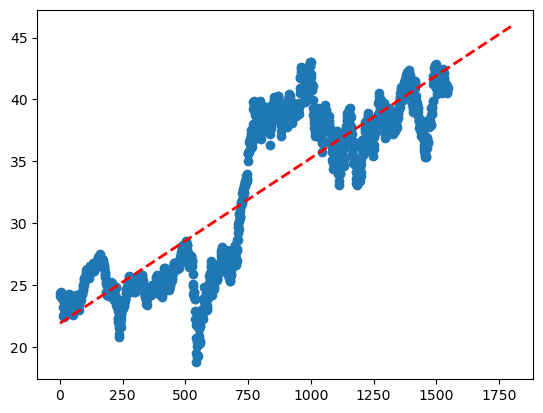

In [3]:
predicted_returns,_ = Combined_Asset_Evaluator('User_755', 0.05, [0.2, 0.22], 10000, 252)
predicted_returns